<a href="https://colab.research.google.com/github/rtrochepy/astronomer/blob/main/preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Documentación del Proceso de Preprocesamiento y Análisis de Datos

## Importar Librerías

In [2]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from joblib import dump, load
from scipy.stats import skew, kurtosis
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
import os
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np

## Leer el Dataset

El primer paso consiste en cargar el conjunto de datos en el entorno de trabajo para su análisis y preprocesamiento.

In [3]:
# Ignorar advertencias de pandas para una ejecución más limpia
warnings.filterwarnings('ignore')

# Configuración de pandas para mostrar todas las columnas al imprimir
pd.set_option('display.max_columns', None)

In [4]:
# Lee el archivo CSV.  Error handling mejorado.
try:
    df = pd.read_csv("data_labels.csv")
except FileNotFoundError:
    print("Error: El archivo 'data_labels.csv' no se encuentra.")
except pd.errors.EmptyDataError:
    print("Error: El archivo 'data_labels.csv' está vacío.")
except pd.errors.ParserError:
    print("Error: Error al analizar el archivo 'data_labels.csv'.")


In [5]:
# ver cuantas filas y columnas tiene (90009 filas, 191 columnas)
df.shape

(90009, 191)

In [6]:
print(f"Filas cargadas: {len(df)}")

Filas cargadas: 90009


In [7]:
# Mostrar las primeras filas y la forma inicial del DataFrame
print("Primeras filas del DataFrame:")
print(df.head())
print("\nDimensiones del DataFrame (filas, columnas):", df.shape)

Primeras filas del DataFrame:
                                                  ID Expenditure_AHF  \
0  1547558447248542464208633772467833372637054433...      2017-10-23   
1  8303023334174375372752224543342433062237135032...      2017-05-16   
2  6205323654737347834626173852036442544385334747...      2017-12-15   
3  3727835411357335232137873674310300621187543222...      2018-02-02   
4  3526827315715777302832343600863305043273474403...      2017-05-31   

   Payment_6804  Infraction_CGP  Base_7744  Base_80863  Risk_1930  \
0      0.983147        0.001925   0.024150    1.009185   0.006479   
1      0.845400        0.001012   0.032260    1.008112   0.001539   
2      0.773748        0.008989   0.007325    0.817528   0.008786   
3      0.853480        0.653419   0.107481    0.816447   0.007058   
4      0.632887        0.000809   0.009320    0.812306   0.001417   

   Expenditure_JIG  Infraction_SNZ  Base_02683  Infraction_SBF  \
0         0.104240        0.005930    0.008182          

## Tratamiento de Valores Nulos (Missing Values)

In [8]:
# Ver los nulos que hay en cada columna
nulos_por_columna = df.isnull().sum()

# Filtrar solo las columnas que tienen valores nulos
nulos_por_columna = nulos_por_columna[nulos_por_columna > 0]
nulos_por_columna

,0
Payment_6804,527
Base_80863,4
Expenditure_JIG,15851
Infraction_SNZ,4
Base_02683,4
...,...
Infraction_QGR,851
Infraction_ZTLC,73406
Infraction_LSX,851
Infraction_IBJ,257


### Eliminación de Columnas con Más del 50% de Valores Nulos

- Las columnas con más del 50% de valores nulos se eliminan del dataset, ya que estimar una gran cantidad de datos faltantes puede distorsionar significativamente los resultados.

In [9]:
# Calcula el umbral para filtrar las columnas
umbral = 0.5 * df.shape[0]

# Elimina las columnas con más del 50% de valores faltantes
df = df.dropna(thresh=umbral, axis=1)
df

,ID,Expenditure_AHF,Payment_6804,Infraction_CGP,Base_7744,Base_80863,Risk_1930,Expenditure_JIG,Infraction_SNZ,Base_02683,Infraction_ZWWJ,Infraction_QJJF,Base_76065,Infraction_EJZ,Base_6872,Risk_0322,Infraction_FMXQ,Infraction_GGO,Infraction_TLPJ,Base_1165,Base_39598,Base_6187,Infraction_ZTNC,Base_85131,Risk_9995,Infraction_AYWV,Payment_22507,Base_9516,Expenditure_YTR,Base_36384,Expenditure_FIP,Infraction_PAS,Risk_0003,Expenditure_HMO,Base_24406,Expenditure_LMSR,Infraction_BSU,Base_14808,Risk_8065,Infraction_ZYW,Base_1039,Infraction_HSSU,Infraction_EHZP,Infraction_TBP,Base_0580,Expenditure_RGD,Infraction_PBC,Infraction_YFSG,Infraction_DQLY,Infraction_AQO,Base_0229,Base_69608,Base_91828,Base_6852,Infraction_CLH,Expenditure_IDZ,Risk_1475,Expenditure_BWX,Base_8511,Infraction_JYZB,Base_22178,Infraction_ZTYG,Infraction_ZVW,Infraction_EYU,Expenditure_UWVG,Base_3041,Payment_3207,Infraction_QKZN,Infraction_CZE,Base_65352,Risk_7095,Infraction_JBR,Base_66195,Base_36516,Infraction_RXQH,Infraction_HFU,Risk_6346,Expenditure_HRQ,Infraction_VTR,Risk_2102,Risk_4804,Base_7331,Infraction_XWX,Expenditure_XDD,Risk_4553,Base_67585,Risk_8742,Infraction_VHU,Risk_4247,Risk_2380,Infraction_GSS,Risk_0454,Base_8730,Expenditure_HKXV,Infraction_MHM,Risk_4160,Risk_3506,Base_23737,Expenditure_GCAO,Risk_9367,Base_7910,Expenditure_GMC,Risk_9423,Risk_6977,Base_9103,Infraction_KSBR,Risk_6178,Risk_6197,Infraction_NRBQ,Infraction_WVC,Infraction_QVSL,Infraction_QXUM,Risk_8532,Risk_9247,Infraction_IMIM,Expenditure_UIWS,Expenditure_ONEG,Expenditure_MTRQ,Expenditure_LAHK,Expenditure_HPM,Infraction_LTIS,Infraction_HFSI,Infraction_ETH,Infraction_SDWM,Base_5441,Base_2810,Risk_8902,Base_67254,Infraction_PTY,Infraction_BGGU,Base_4569,Expenditure_BEH,Infraction_LMHK,Infraction_NMCB,Infraction_TPAF,Infraction_ZRH,Infraction_TEN,Infraction_XEPQ,Infraction_ZMKI,Infraction_WIS,Infraction_RKTA,Infraction_IIZ,Infraction_WVAW,Infraction_KEJT,Infraction_TFOY,Infraction_WMAQ,Infraction_SIA,Infraction_CZXL,Infraction_QEY,Base_52892,Infraction_HUK,Infraction_VHHP,Infraction_LIES,Risk_5270,Infraction_QWWW,Infraction_YQXM,Infraction_QGR,Infraction_LSX,Infraction_IBJ,Infraction_DNOU,label
0,1547558447248542464208633772467833372637054433...,2017-10-23,0.983147,0.001925,0.024150,1.009185,0.006479,0.104240,0.005930,0.008182,0.237006,0.001666,0.034075,0.782012,0.592018,0.000083,0.401435,0.773537,0.016837,0.214074,0.023268,0.003628,1.003458,0.007956,0.009305,0.230541,0.634261,0.302213,0.224713,0.017326,0.006349,1.005259,0.004350,0.086060,0.392125,1.002866,0.077297,0.362511,0.007402,0.001927,0.125249,0.065698,0.891301,0.011131,0.138430,0.447890,0.435724,CR,O,0.001427,0.003501,1.003915,0.004962,0.002425,very_high,0.169760,0.000352,0.685046,0.004583,0.007357,0.003917,0.001006,0.211856,0.000403,0.106730,0.014277,0.006474,0.008729,0.000062,0.005170,0.008738,0.407447,0.003473,0.000733,0.000147,0.008251,0.008654,0.001234,0.002641,0.001386,0.007568,0.005168,0.003912,0.003061,1.009377,0.073624,0.000646,0.000251,0.001865,0.009868,0.001488,0.007390,0.0,0.009381,0.005815,0.005702,0.005891,1,0.001395,0.000361,0.007625,0.007062,0.005643,0.002036,1.001486,0.009347,0.006200,0.008698,0.507619,1.008891,0.005257,0.003046,0.004083,0.001694,0.002168,0.941547,0.139142,0.961532,0.974501,0.632361,0.332749,1.003581,0.965671,0.336258,0.006050,0.016275,1.002439,moderate_low,0.003779,1.002633,0.017646,0.295987,0.005840,1.0,0.186436,0.0,moderate_high,0.187506,0.188509,0.0,0.761997,0.722513,0.001766,0.282657,0.000128,1.0,1.001580,1.004143,0.002886,0.000424,0.005860,0.007086,0.004005,0.004309,1.004339,0.000781,0.874826,1.001004,0.005724,0.189795,0
1,8303023334174375372752224543342433062237135032...,2017-05-16,0.845400,0.001012,0.032260,1.008112,0.001539,0.050516,0.006034,0.003052,NaN,0.000419,0.013843,0.921744,0.038889,0.004846,0.437545,0.665193,0.025762,0.201589,0.031007,0.005277,0.002221,0.007593,0.001155,0.161673,0.625943,0.296767,0.001261,0.013825,0.007859,1.000677,0.009371,0.067886,0.036992,0.671964,0.032608,0.038521,

### Tratamiento de valores faltantes en variables numéricas

La imputación de una gran cantidad de valores faltantes en una columna puede distorsionar los resultados y comprometer la calidad del análisis. Por ello, se ha optado por dividir las columnas en grupos según el tipo de dato y el porcentaje de valores nulos que contienen, con el fin de aplicar estrategias de imputación específicas y optimizadas para cada caso.

**Estrategia de imputación por porcentaje de valores nulos:**

1. **Columnas con menos del 10% de valores nulos (`low_null_columns`)**  
   Estas columnas presentan pocos valores faltantes, por lo que la imputación mediante la **media** es adecuada. Esta estrategia garantiza que la distribución general de los datos no se vea significativamente alterada.

2. **Columnas con entre 10% y 30% de valores nulos (`mid_null_columns`)**  
   Dado que el impacto de los valores atípicos podría ser mayor en este rango, se ha decidido utilizar la **mediana** como método de imputación. La mediana es una opción robusta y menos sensible a outliers, preservando mejor la representatividad de los datos.

3. **Columnas con más del 30% de valores nulos (`high_null_columns`)**  
   En este caso, el alto porcentaje de valores faltantes requiere técnicas más avanzadas. Se recomienda el uso de **Iterative Imputer**, un enfoque que utiliza regresión iterativa para predecir los valores faltantes en función de las relaciones entre las columnas. Esto permite una imputación más precisa y contextual.

**Nota:** La elección de cada técnica se basa en análisis previo y en recomendaciones de la literatura, priorizando la robustez y la minimización del sesgo en los datos.


In [10]:
# Definir las columnas no numéricas
no_numerical = ['ID', 'Expenditure_AHF', 'Infraction_YFSG', 'Infraction_DQLY', 'Infraction_CLH',
                'Base_67254', 'Infraction_TEN', 'Base_8730', 'Base_23737', 'Infraction_NMCB',
                'Infraction_ZRH', 'Infraction_WIS', 'Infraction_WMAQ', 'label']

# Seleccionar solo las columnas numéricas
numerical_columns = [col for col in df.columns if col not in no_numerical]

# Calcular el porcentaje de valores nulos en cada columna numerica
porcentaje_null = df[numerical_columns].isnull().mean() * 100

# Agrupar columnas en función del porcentaje de valores nulos
# Menos del 10% de nulos
low_null_columns = porcentaje_null[porcentaje_null < 10].index
# Entre 10% y 30% de nulos
mid_null_columns = porcentaje_null[(porcentaje_null >= 10) & (porcentaje_null < 30)].index
# Más del 30% de nulos
high_null_columns = porcentaje_null[porcentaje_null >= 30].index

# tratamiento de nulos dependiendo del porcentaje
# Menos del 10% de nulos - rellenar con la media
df[low_null_columns] = df[low_null_columns].fillna(df[low_null_columns].mean())

# Entre 10% y 30% de nulos - rellenar con la mediana
df[mid_null_columns] = df[mid_null_columns].fillna(df[mid_null_columns].median())

# Más del 30% de nulos - usa técnicas avanzadas como Iterative Imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer()
df[high_null_columns] = imputer.fit_transform(df[high_null_columns])

### Tratamiento de valores faltantes en variables categóricas

Para manejar los valores faltantes en columnas categóricas, se ha decidido rellenarlos creando una nueva categoría etiquetada como `"Missing"`. Este enfoque tiene varias ventajas clave:  
- **Preservación de información:** Mantiene la señal de que faltaban datos, lo que podría ser relevante para el modelo.  
- **Evita sesgo:** No altera la distribución original de las categorías.  
- **Identificación de patrones:** Permite al modelo aprender posibles relaciones entre los datos faltantes y otras variables.

Adicionalmente, se ha convertido cada columna categórica al tipo `Categorical`, lo que optimiza el uso de memoria, mejora la eficiencia del procesamiento y facilita el manejo de estas columnas en pandas.

#### Estrategias específicas para el tratamiento de datos categóricos

1. **Binning para columnas ordinales con múltiples niveles detallados:**  
   Columnas como `Infraction_CLH`, `Base_67254`, `Infraction_TEN` tienen categorías ordenadas (`very_high`, `high`, `moderate_high`, `very_low`, etc.).  
   - Se agrupan en categorías más generales (`low`, `moderate`, `high`) para reducir la dimensionalidad sin perder información relevante.  
   - Este enfoque conserva el orden inherente a los datos y permite al modelo detectar patrones con mayor facilidad.  

2. **One-Hot Encoding para columnas nominales sin orden:**  
   Columnas como `Infraction_YFSG` y `Infraction_DQLY` no presentan un orden jerárquico y contienen categorías independientes (por ejemplo, distintos tipos de infracciones).  
   - Se aplica **One-Hot Encoding**, que transforma cada categoría en una columna binaria.  
   - Este método es ideal para modelos de machine learning que no manejan datos categóricos directamente, preservando la naturaleza independiente de las categorías.  

3. **One-Hot Encoding para columnas con pocos valores numéricos:**  
   Columnas como `Base_8730` e `Infraction_WMAQ` tienen valores numéricos limitados (por ejemplo, 0, 1, 2), pero estos no representan cantidades ni un orden claro.  
   - Se tratan como categorías distintas mediante **One-Hot Encoding**, evitando imponer una relación de magnitud o jerarquía que no existe.

4. **Label Encoding para columnas binarias:**  
   Columnas como `Base_23737`, `Infraction_NMCB`, `Infraction_ZRH`, e `Infraction_WIS` tienen solo dos valores (por ejemplo, 0 y 1, o algún valor junto con `"Missing"`).  
   - Se utiliza **Label Encoding**, asignando valores numéricos simples (0 y 1) a las categorías.  
   - Esto es suficiente para columnas binarias, evitando la redundancia de aplicar One-Hot Encoding.

5. **Columna `label` (target):**  
   La columna objetivo ya es binaria (0 y 1) y no requiere procesamiento adicional.


In [11]:
# las variables categoricas son:
categoricas = ['Infraction_YFSG', 'Infraction_DQLY','Infraction_CLH', 'Base_67254', 'Infraction_TEN',
              'Base_8730', 'Base_23737', 'Infraction_NMCB', 'Infraction_ZRH', 'Infraction_WIS',
               'Infraction_WMAQ']

In [12]:
# Mostramos las categorias de cada variable categorica

for i in categoricas:
    print(i, df[i].unique())

Infraction_YFSG ['CR' 'CO' 'CL' 'XZ' 'XM' 'XL']
Infraction_DQLY ['O' 'R' '-1' 'U' nan]
Infraction_CLH ['very_high' 'high' 'moderate_high' 'very_low' 'moderate_low' 'moderate'
 'low' nan]
Base_67254 ['moderate_low' 'low' 'moderate' 'extremely_high' 'high' 'moderate_high'
 'very_high' nan]
Infraction_TEN ['moderate_high' 'moderate' 'extremely_low' 'very_high' 'high'
 'moderate_low' 'low' nan]
Base_8730 [ 0.  1.  2. nan]
Base_23737 [1 0]
Infraction_NMCB [ 1.  0. nan]
Infraction_ZRH [ 0. nan  1.]
Infraction_WIS [ 0.  1. nan]
Infraction_WMAQ [ 1.  0. -1. nan]


In [13]:
# relleno los valores faltantes con 'Missing'
for col in categoricas:
    df[col].fillna('Missing', inplace=True)  # O df[col].fillna(df[col].mode()[0], inplace=True)

# compruebo que los valores faltantes se han rellenado con 'Missing'
for i in categoricas:
    print(i, df[i].unique())

Infraction_YFSG ['CR' 'CO' 'CL' 'XZ' 'XM' 'XL']
Infraction_DQLY ['O' 'R' '-1' 'U' 'Missing']
Infraction_CLH ['very_high' 'high' 'moderate_high' 'very_low' 'moderate_low' 'moderate'
 'low' 'Missing']
Base_67254 ['moderate_low' 'low' 'moderate' 'extremely_high' 'high' 'moderate_high'
 'very_high' 'Missing']
Infraction_TEN ['moderate_high' 'moderate' 'extremely_low' 'very_high' 'high'
 'moderate_low' 'low' 'Missing']
Base_8730 [0.0 1.0 2.0 'Missing']
Base_23737 [1 0]
Infraction_NMCB [1.0 0.0 'Missing']
Infraction_ZRH [0.0 'Missing' 1.0]
Infraction_WIS [0.0 1.0 'Missing']
Infraction_WMAQ [1.0 0.0 -1.0 'Missing']


In [14]:
# Convertir todas las columnas categóricas a tipo 'category' en pandas
df[categoricas] = df[categoricas].astype('category')

In [15]:
# Función para aplicar binning a columnas con un orden implícito, manteniendo la categoría 'Missing'
def binarize_levels_with_missing(column):
    if column == 'Missing':
        return 'Missing'
    elif column in ['very_low', 'low', 'moderate_low', 'extremely_low']:
        return 'low'
    elif column in ['moderate', 'moderate_high']:
        return 'moderate'
    else:
        return 'high'

In [16]:
# Aplicar binning en las columnas que tienen orden implícito
df['Infraction_CLH'] = df['Infraction_CLH'].apply(binarize_levels_with_missing)
df['Base_67254'] = df['Base_67254'].apply(binarize_levels_with_missing)
df['Infraction_TEN'] = df['Infraction_TEN'].apply(binarize_levels_with_missing)

In [17]:
# Aplicar One-Hot Encoding a las columnas con categorías después de binning para incluir 'Missing'
df = pd.get_dummies(df, columns=['Infraction_CLH', 'Base_67254', 'Infraction_TEN'], drop_first=False)

# Aplicar One-Hot Encoding para columnas categóricas sin orden
df = pd.get_dummies(df, columns=['Infraction_YFSG', 'Infraction_DQLY'], drop_first=False)

# Aplicar One-Hot Encoding a las columnas con valores numéricos y pocos valores distintos
df = pd.get_dummies(df, columns=['Base_8730', 'Infraction_WMAQ'], drop_first=False)

In [18]:
# Manejamos columnas binarias, asegurando compatibilidad de tipos antes de aplicar Label Encoding
# Convertimos todos los valores a string en estas columnas para evitar errores de tipo mixto
binary_columns = ['Base_23737', 'Infraction_NMCB', 'Infraction_ZRH', 'Infraction_WIS']
for i in binary_columns:
    # Convertir a string para asegurar consistencia de tipo
    df[i] = df[i].astype(str)

In [19]:
# Aplicar Label Encoding solo en columnas binarias después de la conversión de tipo
le = LabelEncoder()
for i in binary_columns:
    df[i] = le.fit_transform(df[i])

In [20]:
# compruebo que la columna 'label' solo tiene valores de 1,0
df.label.unique()

# Convirtiendo la columna 'fecha' a datetime
df['Expenditure_AHF'] = pd.to_datetime(df['Expenditure_AHF'])

# establecer la columna ID como index
df = df.set_index('ID')

# muestro dataframe para ver las nuevas columnas creadas con los valores "encoded"
df

# checkear que ya no hay nulos
# Contar valores nulos en cada columna
nulos_por_columna_2 = df.isnull().sum()
# Filtrar solo las columnas que tienen valores nulos
nulos_por_columna_2 = nulos_por_columna_2[nulos_por_columna_2 > 0]
nulos_por_columna_2

,0


# Visualización de la distribución de las variables numéricas

Antes de avanzar con la detección de outliers y el escalado de las variables numéricas, es fundamental comprender cómo están distribuidos los datos. Esto permite identificar posibles patrones, asimetrías, o irregularidades que puedan influir en el análisis posterior.

Por ello, se graficarán las distribuciones de las variables numéricas para obtener una visión clara y preliminar de su comportamiento.


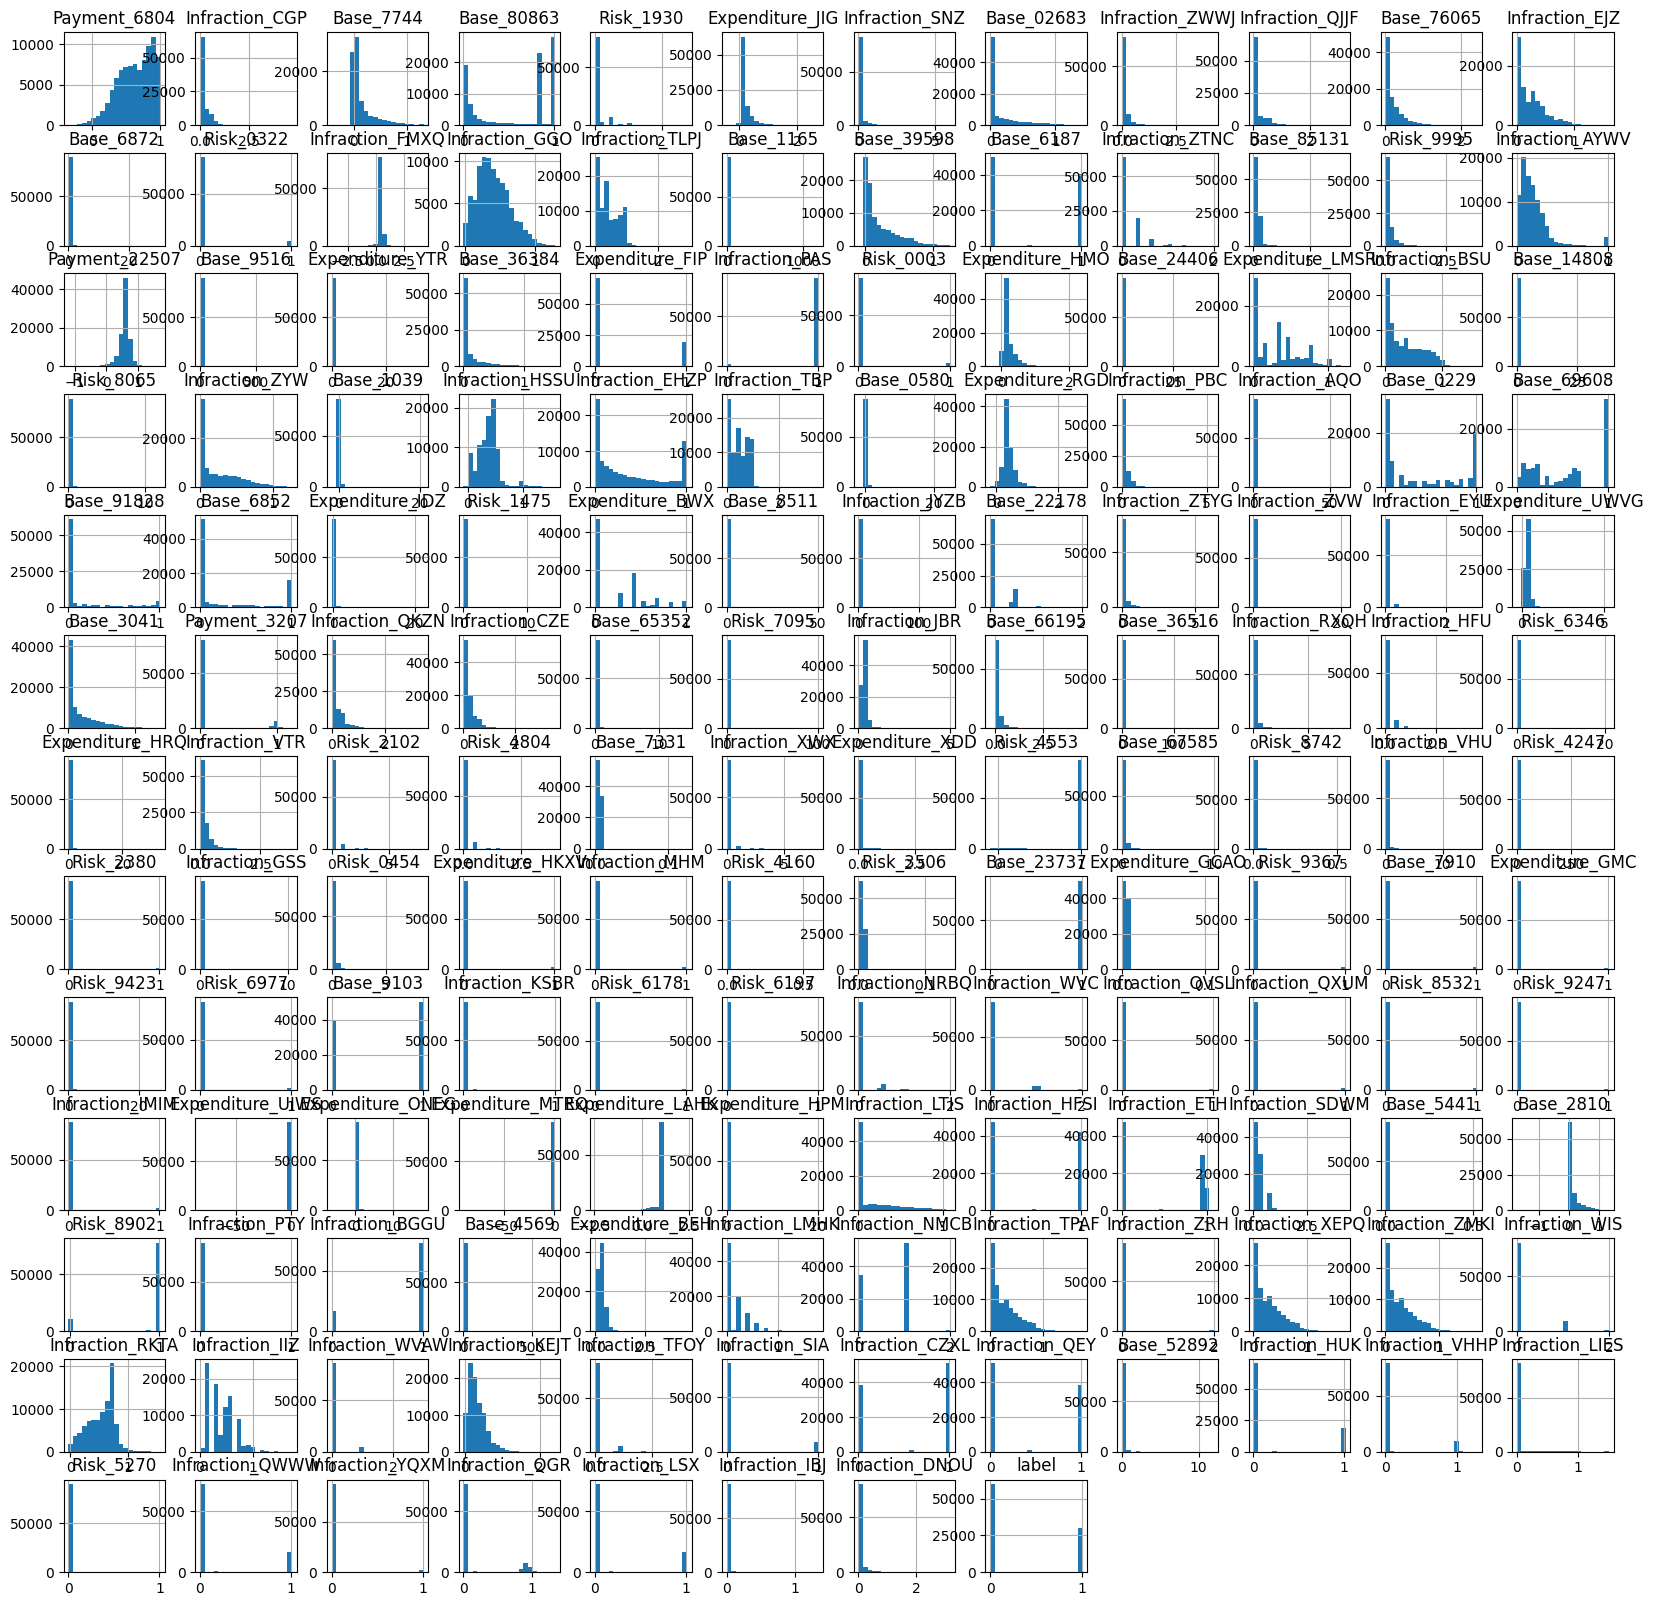

In [21]:
# Selecciona solo las columnas numéricas
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Graficar histogramas en un grid
df[numeric_columns].hist(figsize=(20, 20), bins=20)
plt.show()

# Detección de outliers

La investigación realizada sugiere las siguientes estrategias para identificar outliers:  

- **Método del Rango Intercuartílico (IQR):**  
  Ideal para distribuciones que no son normales y aplicable a cualquier tipo de distribución, ya que se basa en la posición relativa de los datos en lugar de asumir una forma específica.  

- **Z-score:**  
  Útil para detectar outliers en datos con una distribución aproximadamente normal o cuando no es posible determinar la distribución con precisión. Este método evalúa qué tan alejados están los valores en términos de desviaciones estándar de la media.

Dado que, como se observó en la visualización previa de las distribuciones, las variables numéricas no presentan generalmente una distribución normal, se opta por utilizar el método **IQR** para la detección de outliers.  


In [22]:
# Calcular el primer y tercer cuartil
Q1 = df[numeric_columns].quantile(0.25)
Q3 = df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# Identificar outliers como valores fuera de 1.5 veces el IQR
outliers_iqr = ((df[numeric_columns] < (Q1 - 1.5 * IQR)) | (df[numeric_columns] > (Q3 + 1.5 * IQR)))

# Contar el número de outliers por columna
outliers_count_iqr = outliers_iqr.sum(axis=0)
# mostrar todos los registros
pd.options.display.max_rows = None
print("Número de outliers por columna (IQR):\n", outliers_count_iqr)

Número de outliers por columna (IQR):
 Payment_6804          139
Infraction_CGP       6582
Base_7744           11229
Base_80863              0
Risk_1930           13878
Expenditure_JIG     13138
Infraction_SNZ      13702
Base_02683           9575
Infraction_ZWWJ     10223
Infraction_QJJF     14261
Base_76065           4947
Infraction_EJZ       2784
Base_6872           12907
Risk_0322            4820
Infraction_FMXQ     14542
Infraction_GGO        513
Infraction_TLPJ        12
Base_1165            2254
Base_39598           3345
Base_6187               0
Infraction_ZTNC      1887
Base_85131            819
Risk_9995           13058
Infraction_AYWV      3788
Payment_22507        7625
Base_9516            1108
Expenditure_YTR     10785
Base_36384          12188
Expenditure_FIP     19202
Infraction_PAS       2154
Risk_0003            3002
Expenditure_HMO      7064
Base_24406          11190
Expenditure_LMSR       72
Infraction_BSU          5
Base_14808           9020
Risk_8065            3227

In [23]:
# Número total de filas
total_rows = len(df)

# Calcular el porcentaje de outliers en cada columna
outliers_percentage = (outliers_count_iqr / total_rows) * 100
# mostrar todos los registros
pd.options.display.max_rows = None
print("Porcentaje de outliers por columna (IQR):\n", outliers_percentage)

Porcentaje de outliers por columna (IQR):
 Payment_6804         0.154429
Infraction_CGP       7.312602
Base_7744           12.475419
Base_80863           0.000000
Risk_1930           15.418458
Expenditure_JIG     14.596318
Infraction_SNZ      15.222922
Base_02683          10.637825
Infraction_ZWWJ     11.357753
Infraction_QJJF     15.843971
Base_76065           5.496117
Infraction_EJZ       3.093024
Base_6872           14.339677
Risk_0322            5.355020
Infraction_FMXQ     16.156162
Infraction_GGO       0.569943
Infraction_TLPJ      0.013332
Base_1165            2.504194
Base_39598           3.716295
Base_6187            0.000000
Infraction_ZTNC      2.096457
Base_85131           0.909909
Risk_9995           14.507438
Infraction_AYWV      4.208468
Payment_22507        8.471375
Base_9516            1.230988
Expenditure_YTR     11.982135
Base_36384          13.540868
Expenditure_FIP     21.333422
Infraction_PAS       2.393094
Risk_0003            3.335222
Expenditure_HMO      7.8481

# Tratamiento de outliers

De acuerdo con la investigación, es crucial tratar los outliers antes de normalizar o estandarizar los datos. Esto se debe a que los valores extremos pueden distorsionar significativamente estos procesos, afectando tanto la distribución de los datos como el rendimiento de los modelos posteriores.

Se ha optado por el cálculo del porcentaje de outliers en cada columna utilizando el método del **Rango Intercuartílico (IQR)**, que identifica valores que están por encima de 1.5 veces el IQR desde el primer y tercer cuartil. Este enfoque es especialmente efectivo para datos con distribuciones no normales.

### Estrategias para el tratamiento de outliers según su proporción:

1. **Columnas con menos del 5% de outliers:**  
   - **Estrategia:** Eliminación de los outliers.  
   - **Justificación:** Representan una pequeña proporción de los datos, por lo que su eliminación tiene un impacto mínimo en la cantidad total de información. Los valores extremos en estas columnas probablemente no aportan patrones relevantes, y su eliminación mejora la calidad del dataset sin pérdida significativa de información.

2. **Columnas con entre el 5% y el 15% de outliers:**  
   - **Estrategia:** Reemplazo de los outliers con los límites del IQR (mínimo o máximo permitido por el rango intercuartílico).  
   - **Justificación:** Eliminar este porcentaje de outliers podría llevar a una pérdida considerable de datos. Reemplazarlos suaviza su impacto, manteniendo todas las filas en el dataset y reduciendo la influencia de los valores extremos sin eliminarlos.

3. **Columnas con más del 15% de outliers:**  
   - **Estrategia:** Aplicación de transformaciones logarítmicas o de raíz cuadrada.  
   - **Justificación:** Dado que más del 15% de los datos contienen valores extremos, eliminarlos o reemplazarlos podría alterar sustancialmente la estructura de los datos y posiblemente eliminar patrones importantes.  
     - **Transformación logarítmica:** Útil para datos con crecimiento exponencial o gran variabilidad, ya que comprime los valores extremos.  
     - **Transformación de raíz cuadrada:** Suaviza la dispersión sin comprimir tanto como el logaritmo, siendo ideal para datos con variabilidad moderada.


In [24]:
# Filtrar las columnas con menos del 5% de outliers
# Esto selecciona las columnas en las que el porcentaje de outliers es menor al 5%
# Utilizamos 'outliers_percentage' para identificar estas columnas y obtener sus nombres
minor_outlier_columns = outliers_percentage[outliers_percentage < 5].index

# Filtrar filas eliminando los outliers en estas columnas
# Recorremos cada columna en 'minor_outlier_columns' para identificar y eliminar los outliers en esas columnas
for col in minor_outlier_columns:

    # Calculamos el límite inferior de IQR para la columna actual
    # Este límite inferior se define como Q1 - 1.5 * IQR, y cualquier valor por debajo de este se considera un outlier
    lower_limit = Q1[col] - 1.5 * IQR[col]

    # Calculamos el límite superior de IQR para la columna actual
    # Este límite superior se define como Q3 + 1.5 * IQR, y cualquier valor por encima de este se considera un outlier
    upper_limit = Q3[col] + 1.5 * IQR[col]

    # Filtramos el dataframe eliminando las filas con outliers en la columna actual
    # Solo mantenemos las filas donde el valor en la columna está entre el límite inferior y el límite superior
    # Esto elimina todas las filas que contienen valores fuera de los límites permitidos
    df = df[(df[col] >= lower_limit) & (df[col] <= upper_limit)]

In [25]:
# Filtrar las columnas con entre 5% y 15% de outliers
# Esto selecciona las columnas donde el porcentaje de outliers está entre el 5% y el 15%
# Utilizamos los valores en 'outliers_percentage' para crear una lista con los nombres de estas columnas
moderate_outlier_columns = outliers_percentage[(outliers_percentage >= 5) & (outliers_percentage <= 15)].index

# Reemplazar los outliers en estas columnas con los límites de IQR
# Recorremos cada columna en 'moderate_outlier_columns' para aplicar el reemplazo de outliers
for col in moderate_outlier_columns:

    # Calculamos el límite inferior de IQR para la columna actual
    # Este límite inferior es Q1 - 1.5 * IQR y representa el valor más bajo permitido sin considerar outlier
    lower_limit = Q1[col] - 1.5 * IQR[col]

    # Calculamos el límite superior de IQR para la columna actual
    # Este límite superior es Q3 + 1.5 * IQR y representa el valor más alto permitido sin considerar outlier
    upper_limit = Q3[col] + 1.5 * IQR[col]

    # Usamos np.where para reemplazar los valores fuera de los límites en la columna actual
    # Si el valor es menor que el límite inferior, lo reemplaza con 'lower_limit'
    # Si el valor es mayor que el límite superior, lo reemplaza con 'upper_limit'
    # De lo contrario, mantiene el valor original
    df[col] = np.where(df[col] < lower_limit, lower_limit,
                       np.where(df[col] > upper_limit, upper_limit, df[col]))

In [26]:
# Filtrar las columnas con más del 15% de outliers
high_outlier_columns = outliers_percentage[outliers_percentage > 15].index

### Selección del método de transformación

Cuando los outliers representan un patrón potencialmente relevante, pero es necesario reducir su impacto en el análisis, se pueden aplicar **transformaciones logarítmicas** o de **raíz cuadrada**. Estas transformaciones son especialmente útiles para:  
- Distribuciones con **colas largas**.  
- Variables con **escalas muy diferentes**.  

**Justificación del enfoque:**  
Cuando más del 15% de las observaciones en una columna son identificadas como outliers, estos valores podrían no ser verdaderamente "atípicos", sino representar una parte significativa o característica del dataset. En estos casos:  
- **Eliminar** o **reemplazar** los valores extremos con límites como los del IQR podría distorsionar los patrones inherentes de los datos.  
- **Transformaciones** como el logaritmo o la raíz cuadrada reducen la influencia de los valores extremos sin alterar la estructura subyacente de los datos.  

**Ventajas de aplicar transformaciones:**  
1. Reducen el impacto de la **asimetría** y los valores extremos en los datos.  
2. Facilitan una detección más precisa de outliers.  
3. Mejoran la calidad de los datos para el entrenamiento de modelos, al hacerlos más manejables y consistentes.  

Este enfoque no elimina información valiosa, sino que permite una representación más equilibrada de los datos para análisis posteriores.  


In [27]:
# Decidir transformación basada en skewness y kurtosis
for col in high_outlier_columns:
    original_skew = skew(df[col].dropna())
    log_skew = skew(np.log1p(df[col].dropna()))
    sqrt_skew = skew(np.sqrt(df[col].dropna().clip(lower=0)))

    print(f'Columna: {col}')
    print(f'  Skew original: {original_skew}')
    print(f'  Skew logaritmo: {log_skew}')
    print(f'  Skew raíz cuadrada: {sqrt_skew}')

    if abs(log_skew) < abs(sqrt_skew):
        print(f'  Transformación recomendada: Logaritmo')
    else:
        print(f'  Transformación recomendada: Raíz Cuadrada')

Columna: Risk_1930
  Skew original: 5.456626027599812
  Skew logaritmo: 5.2095476091944795
  Skew raíz cuadrada: 4.67394501135592
  Transformación recomendada: Raíz Cuadrada
Columna: Infraction_SNZ
  Skew original: 5.665847718454314
  Skew logaritmo: 4.714515271446761
  Skew raíz cuadrada: 3.572959596747806
  Transformación recomendada: Raíz Cuadrada
Columna: Infraction_QJJF
  Skew original: 2.689509879693611
  Skew logaritmo: 2.2577169388904763
  Skew raíz cuadrada: 1.5134999870528876
  Transformación recomendada: Raíz Cuadrada
Columna: Infraction_FMXQ
  Skew original: 0.6335925537359297
  Skew logaritmo: nan
  Skew raíz cuadrada: -2.1878623743229
  Transformación recomendada: Raíz Cuadrada
Columna: Expenditure_FIP
  Skew original: 1.0412872482070963
  Skew logaritmo: 1.04115584324963
  Skew raíz cuadrada: 1.0332872468727852
  Transformación recomendada: Raíz Cuadrada
Columna: Base_0580
  Skew original: 8.709383482324633
  Skew logaritmo: 7.077929228382815
  Skew raíz cuadrada: 4.7563

In [28]:
# Columnas recomendadas para raíz cuadrada
sqrt_columns = [
    'Risk_1930', 'Infraction_SNZ', 'Infraction_QJJF', 'Infraction_FMXQ',
    'Expenditure_FIP', 'Base_0580', 'Base_91828', 'Expenditure_IDZ',
    'Base_22178', 'Infraction_ZVW', 'Infraction_JBR', 'Expenditure_UIWS',
    'Expenditure_MTRQ', 'Expenditure_HPM', 'Infraction_HUK', 'Infraction_QWWW',
    'Infraction_QGR', 'Infraction_LSX', 'Infraction_DNOU'
]

# Columnas recomendadas para logaritmo
log_columns = ['Infraction_BGGU']

# Aplicar transformaciones Raíz cuadrada
for col in sqrt_columns:
    df[col] = np.sqrt(df[col].clip(lower=0))  # Asegura que no haya valores negativos

# Aplicar transformaciones Logaritmo
for col in log_columns:
    df[col] = np.log1p(df[col].clip(lower=0))  # log1p(x) es log(1 + x) y evita problemas con ceros

# División de los datos en variables predictoras (X) y variable objetivo (y)

1. **Conversión de columnas categóricas:**  
   - Las columnas `Infraction_NMCB`, `Infraction_ZRH`, y `Infraction_WIS` se convierten de tipo `int` a `category`.  
   - **Justificación:** Estas columnas tienen valores como `0`, `1`, y `2`, que no representan cantidades numéricas, sino categorías. Realizar esta conversión evita que se interpreten como números enteros durante el procesamiento.

2. **Conversión de columnas booleanas:**  
   - Las columnas de tipo `bool` se convierten a `int`.  
   - **Justificación:** Algunos modelos de machine learning no soportan directamente el tipo `bool`. Convertirlas a `int` asegura compatibilidad, representando `True` como `1` y `False` como `0`.

3. **Eliminación de columnas sin variabilidad:**  
   - Se elimina la columna `Base_23737` porque tiene un único valor (`1`) en todas las filas.  
   - **Justificación:** Una columna sin variabilidad no aporta información útil para el modelo y puede generar ruido innecesario.

4. **Eliminación de la columna de fecha:**  
   - Se elimina la columna `fecha`, ya que no parece tener una relación directa con la variable objetivo.  
   - **Justificación:** La columna parece ser únicamente una marca temporal y no aporta información relevante para el problema de predicción.

In [29]:
df.label.unique()
df.Infraction_WIS.unique()
df.Infraction_ZRH.unique()
df.Infraction_NMCB.unique()
df.Base_23737.unique()
# Convertir columnas categóricas con valores int a category
categorical_int_columns = ['Infraction_NMCB', 'Infraction_ZRH', 'Infraction_WIS']
for col in categorical_int_columns:
    df[col] = df[col].astype('category')

# Convertir columnas booleanas a int
boolean_columns = df.select_dtypes(include=['bool']).columns
df[boolean_columns] = df[boolean_columns].astype(int)

# Eliminar columnas constantes (si es el caso)
df = df.drop(columns=['Expenditure_AHF','Base_23737'])
df.dtypes
df.isnull().sum()

,0
Payment_6804,0
Infraction_CGP,0
Base_7744,0
Base_80863,0
Risk_1930,0
Expenditure_JIG,0
Infraction_SNZ,0
Base_02683,0
Infraction_ZWWJ,0
Infraction_QJJF,0



### División de los datos en variables predictoras (X) y variable objetivo (y)

En este paso, separamos la variable objetivo (`label`), que es el objetivo de la predicción, del resto de las variables predictoras.  

- **Importancia:** La variable objetivo no debe influir en las transformaciones aplicadas a las variables predictoras para evitar introducir sesgos en el preprocesamiento y garantizar que el modelo aprenda patrones genuinos.  
- **Resultado:** Se obtiene un conjunto de variables predictoras (`X`) y la variable objetivo (`y`), preparándolos para las siguientes etapas del análisis y modelado.  


In [30]:
# 'X' contendrá todas las columnas excepto 'label', que es la variable objetivo
X = df.drop(columns=['label'])

# 'y' contendrá únicamente la columna 'label', que es la variable objetivo a predecir
y = df['label']

## División de los Datos en Conjuntos de Entrenamiento y Prueba

Es fundamental separar los datos en conjuntos de entrenamiento y prueba antes de realizar cualquier transformación o preprocesamiento. Esto asegura que:  

- El conjunto de prueba **permanezca independiente** del conjunto de entrenamiento.  
- Las decisiones de preprocesamiento no se vean influenciadas por información derivada del conjunto de prueba, evitando así sesgos y garantizando una evaluación más precisa del modelo.  

Esta práctica es clave para simular cómo el modelo se desempeñará con datos no vistos y garantizar la validez de los resultados.  



In [ ]:
# Dividir los datos en entrenamiento (70%) y prueba (30%) con una semilla para reproducibilidad
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Tratamiento de Datos Desbalanceados (si aplica)

Cuando la variable objetivo está desbalanceada, existe el riesgo de que el modelo aprenda a favorecer la clase mayoritaria, lo que puede afectar su capacidad para predecir correctamente las clases minoritarias.  

En caso de detectar un desbalance, las clases se balancearán **únicamente en el conjunto de entrenamiento**. Esto asegura que:  
- El modelo aprenda de un conjunto equilibrado, mejorando su capacidad para identificar patrones en todas las clases.  
- El conjunto de prueba permanezca representativo del dataset original, permitiendo evaluar el rendimiento del modelo en condiciones reales.  

Este enfoque garantiza una evaluación imparcial y realista del desempeño del modelo en datos no vistos.  


In [ ]:
# Contar la cantidad de cada clase en y_train
class_counts = y_train.value_counts()
print("Distribución de clases en el conjunto de entrenamiento:\n", class_counts)

# Calcular el porcentaje de cada clase en y_train para ver si está desbalanceado
class_percentage = y_train.value_counts(normalize=True) * 100
print("Porcentaje de cada clase en el conjunto de entrenamiento:\n", class_percentage)


## Tratamiento de Datos Desbalanceados

Dado el análisis de las proporciones de la variable objetivo, se observa un desbalance significativo:  
- La clase mayoritaria (`0`) representa el **78.6%** de las observaciones.  
- La clase minoritaria (`1`) representa solo el **21.4%**.  

Este desbalance podría afectar negativamente el rendimiento del modelo de clasificación, ya que sin un tratamiento adecuado, el modelo podría inclinarse a favorecer la clase mayoritaria, disminuyendo su capacidad para predecir correctamente la clase minoritaria.

### Estrategias consideradas para tratar el desbalance:
Basado en la investigación y las características observadas en los datos (como cierta asimetría en algunas columnas), se consideran las siguientes técnicas avanzadas:  

1. **ADASYN (Adaptive Synthetic Sampling):**  
   - Genera ejemplos sintéticos de la clase minoritaria en áreas menos representadas.  
   - Es especialmente útil para datos con distribuciones complejas y clases minoritarias dispersas.  

2. **SMOTE-ENN (Synthetic Minority Oversampling Technique + Edited Nearest Neighbors):**  
   - Combina el balanceo mediante la generación de ejemplos sintéticos (SMOTE) con la eliminación de ejemplos ambiguos o ruidosos (ENN).  
   - Resulta útil cuando se sospecha la presencia de ruido en los datos y se desea un dataset más limpio.  

### Enfoque:
Se implementarán ambas técnicas (ADASYN y SMOTE-ENN) para el balanceo del conjunto de entrenamiento, y se evaluará cuál de ellas proporciona un mejor rendimiento en el conjunto de prueba. Esto garantizará que el modelo tenga un desempeño óptimo en datos no vistos y mejore su capacidad de generalización.


In [ ]:
# Decisión: Si alguna clase representa una proporción pequeña (por ejemplo, <20% frente a otra clase),
# entonces podemos considerar los datos desbalanceados y aplicar técnicas de balanceo.

# Crear un objeto ADASYN para el oversampling adaptativo de la clase minoritaria
adasyn = ADASYN(random_state=42)

# Aplicar ADASYN en el conjunto de entrenamiento
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# Comprobar la nueva distribución de clases después de aplicar ADASYN
print("Distribución de clases después de aplicar ADASYN:\n", y_train_adasyn.value_counts())

# Crear un objeto SMOTEENN para combinar SMOTE y ENN
smote_enn = SMOTEENN(random_state=42)

# Aplicar SMOTEENN en el conjunto de entrenamiento
X_train_smoteenn, y_train_smoteenn = smote_enn.fit_resample(X_train, y_train)

# Comprobar la nueva distribución de clases después de aplicar SMOTEENN
print("Distribución de clases después de aplicar SMOTEENN:\n", y_train_smoteenn.value_counts())

# Ver los nulos que hay en cada columna
nulos_por_columna_adasyn = X_train_adasyn.isnull().sum()

# Filtrar solo las columnas que tienen valores nulos
nulos_por_columna_adasyn = nulos_por_columna_adasyn[nulos_por_columna_adasyn > 0]
nulos_por_columna_adasyn

# Ver los nulos que hay en cada columna
nulos_por_columna_smoteenn = X_train_smoteenn.isnull().sum()
# Filtrar solo las columnas que tienen valores nulos
nulos_por_columna_smoteenn = nulos_por_columna_smoteenn[nulos_por_columna_smoteenn > 0]
nulos_por_columna_smoteenn

### Manejo de valores nulos en columnas categóricas tras aplicar ADASYN y SMOTE-ENN

Al utilizar técnicas de generación de ejemplos sintéticos como **ADASYN** y **SMOTE-ENN**, es posible que aparezcan valores nulos en columnas categóricas. Esto ocurre porque estas técnicas interpolan valores entre instancias cercanas para crear nuevos ejemplos, lo que puede generar combinaciones que no corresponden directamente a las categorías originales, resultando en valores faltantes (`NaN`).

**Solución propuesta:**  
Dado que las categorías suelen estar representadas por valores discretos, reemplazar los valores nulos con la **moda** de cada columna es una opción razonable.  
- **Ventajas de usar la moda:**  
  - Preserva la naturaleza categórica de los datos.  
  - Mantiene la coherencia con la distribución original de las categorías.  
  - Evita la introducción de sesgos significativos en el dataset balanceado.  

Este enfoque asegura que los datos sintéticos generados sean compatibles con las categorías originales y puedan ser utilizados de manera efectiva en los modelos de aprendizaje.  


In [31]:
# Definir las columnas categóricas con valores nulos después de aplicar ADASYN y SMOTEENN
categorical_columns_with_nan = ['Infraction_NMCB', 'Infraction_ZRH', 'Infraction_WIS']

# Rellenar los nulos en X_train_adasyn
for col in categorical_columns_with_nan:
    mode_value = X_train_adasyn[col].mode()[0]  # Obtener la moda de la columna en X_train_adasyn
    X_train_adasyn[col].fillna(mode_value, inplace=True)  # Rellenar con la moda

# Verificar que no queden valores nulos en X_train_adasyn
print("Valores nulos después de imputación en X_train_adasyn:\n", X_train_adasyn[categorical_columns_with_nan].isnull().sum())

# Rellenar los nulos en X_train_smoteenn
for col in categorical_columns_with_nan:
    mode_value = X_train_smoteenn[col].mode()[0]  # Obtener la moda de la columna en X_train_smoteenn
    X_train_smoteenn[col].fillna(mode_value, inplace=True)  # Rellenar con la moda

# Verificar que no queden valores nulos en X_train_smoteenn
print("Valores nulos después de imputación en X_train_smoteenn:\n", X_train_smoteenn[categorical_columns_with_nan].isnull().sum())

df = pd.get_dummies(df, columns=['Infraction_NMCB', 'Infraction_ZRH', 'Infraction_WIS'], drop_first=True)


Distribución de clases en el conjunto de entrenamiento:
 label
0    23352
1     6335
Name: count, dtype: int64
Porcentaje de cada clase en el conjunto de entrenamiento:
 label
0    78.660693
1    21.339307
Name: proportion, dtype: float64
Distribución de clases después de aplicar ADASYN:
 label
0    23352
1    22698
Name: count, dtype: int64
Distribución de clases después de aplicar SMOTEENN:
 label
1    23108
0    20776
Name: count, dtype: int64
Valores nulos después de imputación en X_train_adasyn:
 Infraction_NMCB    0
Infraction_ZRH     0
Infraction_WIS     0
dtype: int64
Valores nulos después de imputación en X_train_smoteenn:
 Infraction_NMCB    0
Infraction_ZRH     0
Infraction_WIS     0
dtype: int64


### Evaluación de ADASYN y SMOTE-ENN

Para comparar el desempeño de las técnicas de balanceo **ADASYN** y **SMOTE-ENN**, se utilizará un **RandomForestClassifier** y se evaluará el modelo utilizando tres métricas clave:  

1. **Balanced Accuracy:**  
   - Mide la precisión general considerando ambas clases, corrigiendo el desbalance en los datos.  
   - Útil para evaluar cómo de bien el modelo clasifica tanto la clase mayoritaria como la minoritaria.  

2. **F1-Score:**  
   - Combina precisión y recall en una sola métrica, enfocándose especialmente en el rendimiento sobre la clase minoritaria.  
   - Ideal para datasets desbalanceados donde la predicción correcta de la clase minoritaria es crucial.  

3. **ROC AUC:**  
   - Evalúa la capacidad del modelo para separar las dos clases, considerando todas las umbrales posibles.  
   - Una métrica robusta para analizar la discriminación entre clases.

### Selección de la técnica de balanceo

Se compararán las métricas de interés para ambas técnicas (ADASYN y SMOTE-ENN) en el conjunto de prueba. La técnica que maximice métricas como el **F1-Score** y la **Balanced Accuracy** será seleccionada como la mejor opción para este problema.  


In [32]:
# Definir una función para entrenar y evaluar un modelo
def evaluate_model(X_train, y_train, X_test, y_test):
    # Crear el modelo de Random Forest
    model = RandomForestClassifier(random_state=42)
    # Entrenar el modelo en el conjunto de entrenamiento balanceado
    model.fit(X_train, y_train)
    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)
    # Calcular las métricas de evaluación
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    f1 = f1_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    return roc_auc, f1, balanced_acc

# Evaluar el modelo con datos balanceados por ADASYN
roc_auc_adasyn, f1_adasyn, balanced_acc_adasyn = evaluate_model(X_train_adasyn, y_train_adasyn, X_test, y_test)

# Evaluar el modelo con datos balanceados por SMOTE-ENN
roc_auc_smoteenn, f1_smoteenn, balanced_acc_smoteenn = evaluate_model(X_train_smoteenn, y_train_smoteenn, X_test, y_test)

# Mostrar los resultados
print("Resultados con ADASYN:")
print(f"ROC AUC: {roc_auc_adasyn:.4f}, F1-Score: {f1_adasyn:.4f}, Balanced Accuracy: {balanced_acc_adasyn:.4f}")
print("\nResultados con SMOTE-ENN:")
print(f"ROC AUC: {roc_auc_smoteenn:.4f}, F1-Score: {f1_smoteenn:.4f}, Balanced Accuracy: {balanced_acc_smoteenn:.4f}")

Resultados con ADASYN:
ROC AUC: 0.9632, F1-Score: 0.8169, Balanced Accuracy: 0.9026

Resultados con SMOTE-ENN:
ROC AUC: 0.9569, F1-Score: 0.7930, Balanced Accuracy: 0.9019


### Selección de la técnica de balanceo: ADASYN

Dado que **ADASYN** muestra un mejor rendimiento en métricas clave como **ROC AUC** y **F1-Score**, resulta ser la opción más adecuada para este problema. Estas métricas son particularmente importantes para evaluar la capacidad del modelo de clasificar correctamente la clase minoritaria, lo que es esencial en datasets desbalanceados.  

Aunque la diferencia en el rendimiento entre ADASYN y SMOTE-ENN es pequeña, **ADASYN** ofrece un desempeño ligeramente superior de manera consistente, lo que respalda su elección como la técnica de balanceo preferida.  


# Escalado de las Variables Numéricas

El escalado de las variables numéricas es un paso crucial en el preprocesamiento, ya que asegura que todas las variables estén en una escala comparable. Esto es especialmente importante para algoritmos sensibles a las magnitudes de los datos.  

**Importancia del escalado:**  
- Escalar los datos **después de la división** en conjuntos de entrenamiento y prueba evita que la información del conjunto de prueba influya en el proceso de escalado del conjunto de entrenamiento, asegurando una evaluación justa y sin sesgos.  
- Elegir entre normalización y estandarización depende tanto de la distribución de los datos como del algoritmo de clasificación que planeas utilizar.  

### Tipos de escalado:

1. **Normalización:**  
   - Escala los valores para que estén en un rango específico, generalmente entre `0` y `1`.  
   - **Cuándo usarla:**  
     - Cuando los datos tienen rangos muy variados o no se tienen suposiciones sobre su distribución.  
     - Ideal para algoritmos que se basan en distancias o relaciones entre datos, como **k-NN** y **Redes Neuronales**.  

2. **Estandarización:**  
   - Transforma los datos para que tengan una **media de 0** y una **desviación estándar de 1**.  
   - **Cuándo usarla:**  
     - Cuando los datos están distribuidos alrededor de una media y los valores extremos son importantes.  
     - Es útil para algoritmos que se benefician de la interpretación de desviaciones respecto a la media, como **Regresión Logística**, **SVM con kernel lineal**, **Árboles de Decisión** y **Random Forest**.  

### Consideraciones:  
La selección entre normalización y estandarización debe basarse en las características de los datos y los requisitos del modelo para maximizar su desempeño.  


### Distribución de los Datos

Después de aplicar los tratamientos correspondientes a los datos, es importante analizar nuevamente su distribución. Esto permite evaluar si las transformaciones realizadas han homogeneizado los datos o si persisten características específicas, como asimetrías o valores extremos.

Para ello, se analizarán dos indicadores clave: **asimetría (skewness)** y **kurtosis**, los cuales proporcionan información sobre la forma y las características de la distribución de los datos:

#### Asimetría (Skewness):  
Describe el grado de simetría de la distribución.  
- **Skewness ≈ 0:** La distribución es aproximadamente simétrica.  
- **Skewness > 0:** Indica una cola larga hacia la derecha (asimetría positiva).  
- **Skewness < 0:** Indica una cola larga hacia la izquierda (asimetría negativa).  

#### Curtosis (Kurtosis):  
Mide la forma de las colas de la distribución y la concentración de datos alrededor de la media.  
- **Kurtosis ≈ 3:** La distribución es **mesocúrtica**, similar a una distribución normal.  
- **Kurtosis > 3:** La distribución es **leptocúrtica**, con colas largas y más valores extremos.  
- **Kurtosis < 3:** La distribución es **platicúrtica**, con colas más cortas y una curva más plana.  

Este análisis es útil para entender cómo se comportan los datos después de los ajustes y para identificar si se requieren pasos adicionales, como transformaciones para reducir asimetrías o manejar valores extremos.  


In [33]:
# Seleccionar solo las columnas numéricas
numeric_columns = X_train_adasyn.select_dtypes(include=['float64', 'int64']).columns

# Crear un dataframe para almacenar los resultados
distribution_info = pd.DataFrame(index=numeric_columns, columns=['Skewness', 'Kurtosis'])

# Calcular skewness y kurtosis para cada columna numérica
for col in numeric_columns:
    distribution_info.loc[col, 'Skewness'] = skew(X_train_adasyn[col].dropna())
    distribution_info.loc[col, 'Kurtosis'] = kurtosis(X_train_adasyn[col].dropna())

# Mostrar el dataframe de skewness y kurtosis
print(distribution_info)


                          Skewness     Kurtosis
Payment_6804             -0.113459    -0.936016
Infraction_CGP            1.416106     0.663808
Base_7744                 1.268696     0.124412
Base_80863               -0.403776    -1.598229
Risk_1930                 3.860478    14.637381
Expenditure_JIG           0.629373    -0.409863
Infraction_SNZ            3.094259      9.70212
Base_02683                1.474733     0.851135
Infraction_ZWWJ           0.790577    -0.383667
Infraction_QJJF           1.011633    -0.066511
Base_76065                1.264712     0.832884
Infraction_EJZ            1.134151     0.552948
Base_6872                 1.457519     0.769915
Risk_0322                 0.004905    -1.071436
Infraction_FMXQ          -2.154702    18.346818
Infraction_GGO            0.582786    -0.073592
Infraction_TLPJ           0.416783    -0.945094
Base_1165                 0.968842     0.160666
Base_39598                1.155526     0.382733
Base_6187                -0.158482    -1

### Aplicación de Estandarización

Se observa que los datos presentan **asimetría** y **valores extremos** en varias variables. Para abordar este problema y preparar los datos para el uso de modelos sensibles a la escala de las variables, como **SVM lineal**, **Regresión Logística** o **Random Forest**, se aplicará la **Estandarización** utilizando `StandardScaler`.

**Beneficios de la estandarización:**  
- Centra las variables en torno a una **media de 0** y las escala para que tengan una **desviación estándar de 1**.  
- Ayuda a manejar la dispersión de los datos de manera más adecuada, reduciendo el impacto de valores extremos en los algoritmos que se benefician de una distribución centrada.  
- Garantiza que todas las variables contribuyan de manera equilibrada a los cálculos, mejorando el desempeño de los modelos de clasificación y regresión.

Este paso es crucial para optimizar el rendimiento de los modelos seleccionados y asegurar una mejor interpretación de los datos durante el entrenamiento.  


In [34]:
# Seleccionar las columnas numéricas
numeric_columns = X_train_adasyn.select_dtypes(include=['float64', 'int64']).columns

# Crear el objeto StandardScaler
scaler = StandardScaler()

# Ajustar y transformar los datos de entrenamiento y de prueba
X_train_adasyn[numeric_columns] = scaler.fit_transform(X_train_adasyn[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])  # Solo transformamos X_test



# Evaluación y Selección de Características

La **selección de características** es un paso clave en el preprocesamiento de datos que busca reducir el número de variables de entrada, con el objetivo de:  
- **Mejorar el rendimiento del modelo:** Al eliminar características irrelevantes o redundantes, el modelo puede centrarse en las variables más significativas.  
- **Reducir el ruido:** Disminuye la complejidad del modelo y el riesgo de sobreajuste.  

### Técnicas de selección de características:

1. **Método de filtro:**  
   - Selecciona las variables más relevantes basándose en métricas estadísticas, como el **ANOVA F-score**.  
   - Este enfoque es rápido y efectivo para identificar características con una fuerte relación estadística con la variable objetivo.  

2. **Método de wrapper:**  
   - Utiliza un modelo para seleccionar las características más importantes mediante estrategias iterativas, como **Recursive Feature Elimination (RFE)**.  
   - Este método evalúa combinaciones de características y selecciona aquellas que maximizan el desempeño del modelo.  

### Enfoque:  
Se probarán ambos métodos (filtro y wrapper) para determinar cuál se adapta mejor a los datos y mejora el rendimiento del modelo. Posteriormente, se seleccionará el método más efectivo según los resultados obtenidos.  


In [ ]:
# Seleccionar las 20 características más relevantes según ANOVA F-score
selector = SelectKBest(score_func=f_classif, k=20)
X_train_selected = selector.fit_transform(X_train_adasyn, y_train_adasyn)
X_test_selected = selector.transform(X_test)


### Método de Filtro: SelectKBest con ANOVA F-score

El **ANOVA F-score** es una métrica ampliamente utilizada en métodos de filtro, ya que mide la relación entre la **varianza entre grupos** y la **varianza dentro de los grupos**.  

**Ventajas del ANOVA F-score:**  
- Es particularmente útil cuando se trabaja con un gran número de características, ya que permite identificar rápidamente las más relevantes.  
- Proporciona un **ranking** claro de las características basándose en su importancia estadística, lo que facilita el proceso de selección.  

El método **SelectKBest** con ANOVA F-score permite seleccionar un subconjunto óptimo de características para el modelo, priorizando aquellas que tienen una mayor relación con la variable objetivo.  


In [ ]:
# Obtener los nombres de las características seleccionadas
selected_features = selector.get_support(indices=True)  # Obtener los índices de las características seleccionadas
selected_feature_names = X_train_adasyn.columns[selected_features]  # Obtener los nombres de las características seleccionadas

# Mostrar las características seleccionadas
print("Características seleccionadas por SelectKBest:\n", selected_feature_names)


### Método de Wrapper: Recursive Feature Elimination (RFE) con Random Forest

El **Recursive Feature Elimination (RFE)** es un método iterativo de selección de características que entrena un modelo para evaluar la importancia de cada característica, eliminando las menos relevantes de forma progresiva.  

**Cómo funciona RFE:**  
1. RFE entrena un modelo base (en este caso, un **Random Forest**) utilizando todas las características disponibles.  
2. Evalúa la importancia de cada característica según las métricas del modelo.  
3. Elimina la característica menos relevante y vuelve a entrenar el modelo.  
4. Repite este proceso hasta alcanzar el número deseado de características.  

**Ventajas de RFE:**  
- **Considera interacciones:** Tiene en cuenta las interacciones entre características, lo que lo hace ideal cuando estas relaciones son relevantes para el desempeño del modelo.  
- **Precisión en la selección:** Evalúa el impacto real de cada característica en el modelo, proporcionando un subconjunto optimizado de variables.  
- Aunque es más exhaustivo y consume más recursos computacionales que otros métodos, es una opción robusta para identificar las características más influyentes.  

**En este caso:**  
Se utiliza RFE con Random Forest para identificar las **30 características más importantes** que contribuyen al desempeño del modelo.  


In [ ]:
# Archivo para guardar el checkpoint
checkpoint_file = "rfe_checkpoint.pkl"

# Verificar si existe un checkpoint previo
if os.path.exists(checkpoint_file):
    # Cargar el estado del RFE desde el checkpoint
    rfe = load(checkpoint_file)
    print("Checkpoint cargado. RFE retomará desde el último estado.")
else:
    # Crear el modelo base y configurar RFE
    model = RandomForestClassifier(random_state=42)
    rfe = RFE(estimator=model, n_features_to_select=30)

# Ajustar RFE y guardar el estado después de cada paso
try:
    # Ajustar RFE al conjunto de entrenamiento
    X_train_rfe = rfe.fit_transform(X_train_adasyn, y_train_adasyn)
    X_test_rfe = rfe.transform(X_test)

    # Guardar el estado completo del objeto RFE
    dump(rfe, checkpoint_file)
    print("RFE completado y guardado en el checkpoint.")
except KeyboardInterrupt:
    # Guardar el estado actual si se interrumpe manualmente
    dump(rfe, checkpoint_file)
    print("Proceso interrumpido. Estado guardado en el checkpoint.")


Características seleccionadas por SelectKBest:
 Index(['Payment_6804', 'Base_80863', 'Infraction_QJJF', 'Base_76065',
       'Infraction_TLPJ', 'Base_1165', 'Base_39598', 'Base_85131', 'Base_9516',
       'Infraction_BSU', 'Infraction_ZYW', 'Infraction_TBP', 'Infraction_PBC',
       'Base_0229', 'Base_69608', 'Base_3041', 'Infraction_QKZN',
       'Infraction_CZE', 'Base_9103', 'Base_67254_low'],
      dtype='object')


In [ ]:
# Obtener las características seleccionadas después de finalizar
selected_features = rfe.support_
feature_names = X_train_adasyn.columns[selected_features]
print("Características seleccionadas por RFE:\n", feature_names)


## Desescalado y Restablecimiento del Dataset Final

En este paso, se realizan varias acciones para preparar el dataset final y combinar los diferentes conjuntos de datos en un único DataFrame (`df_final`):  

1. **Desescalado de los datos:**  
   - Se revierte el escalado aplicado previamente a las variables numéricas para que los valores vuelvan a su escala original.  
   - Esto es útil para interpretar los resultados en el contexto original de los datos, especialmente cuando se necesita presentar o analizar los valores en su forma natural.

2. **Restablecimiento del dataset:**  
   - Los datos procesados se reorganizan y restauran para asegurar que cada columna conserve su estructura y significado original.  
   - Se verifica que los nombres de las columnas, los tipos de datos y los valores estén correctamente alineados.  

3. **Combinación de conjuntos de datos:**  
   - Se fusionan los datos procesados del conjunto de entrenamiento y prueba (o cualquier subconjunto separado) en un único DataFrame final.  
   - Esto permite consolidar toda la información necesaria en un solo lugar para facilitar el análisis y los pasos finales, como la evaluación del modelo.  

**Resultado:**  
El DataFrame final (`df_final`) contiene los datos procesados, combinados y listos para su análisis o uso posterior en el pipeline de machine learning.  


In [ ]:
# Desescalar las columnas numéricas en los conjuntos de entrenamiento y prueba
X_train_adasyn[numeric_columns] = scaler.inverse_transform(X_train_adasyn[numeric_columns])
X_test[numeric_columns] = scaler.inverse_transform(X_test[numeric_columns])


In [ ]:
# Restablecer los índices de X_test y y_test antes de la concatenación
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [ ]:
# Crear DataFrames con la variable objetivo 'y_train_adasyn' y 'y_test'
train_df = pd.concat([X_train_adasyn, y_train_adasyn.reset_index(drop=True)], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)


In [ ]:
# Combinar ambos conjuntos de datos en uno solo
df_final = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

# Verificar el resultado
df_final.head()

df_final.shape


## Creación de DataFrame con las Columnas Seleccionadas por los Métodos de Selección

En este paso, se construye un nuevo DataFrame que combina las columnas seleccionadas por los distintos métodos de selección de características aplicados (por ejemplo, **SelectKBest** y **RFE**).  

**Objetivo:**  
Consolidar las características más relevantes identificadas por ambos métodos para optimizar el modelo final, asegurando que estas variables tengan un impacto significativo en el desempeño.


In [ ]:
# Crear un conjunto único de características seleccionadas
selected_features = set(selected_feature_names).union(set(feature_names))


In [ ]:
# Filtrar df_final para incluir solo las características seleccionadas y la columna objetivo 'label'
df_final_completo = df_final[list(selected_features) + ['label']]


In [ ]:
# Verificar el resultado
df_final_completo.head()


In [ ]:
df_final_completo.shape


In [ ]:
df_final_completo.to_csv('processed_dataset_to_train_models.csv', index=False)